## Comparing KNNBaseline and NMF algorithms

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, KNNBaseline
from surprise import Dataset, Reader
from surprise.accuracy import rmse

import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
sample = pd.read_csv('../data/books_reviews_sample.csv')
sample.head(2)

,book_id,title,user_id,rating
0,5,Harry Potter and the Prisoner of Azkaban (Harr...,84f866eb6dae54d7ac52d45a4c9b4d1f,4
1,5,Harry Potter and the Prisoner of Azkaban (Harr...,f1b86bf7c103c46fcb854e1fb711b1ec,5


In [3]:
# Reorder columns to make dataframe readable for Surprise

ratings = sample[['user_id', 'book_id', 'rating']]

In [4]:
ratings.shape

(91567, 3)

In [5]:
# Create reader

reader = Reader(rating_scale=(1,5))

In [6]:
# Load dataset

dataset = Dataset.load_from_df(ratings,reader)

In [7]:
# Instantiate algorithms

# KNNBaseline
bsl_options = {'method': 'sgd',
               'reg': .08,
               'learning_rate': .005,
               'n_epochs': 40}
              
sim_options = {'name': 'msd',
               'min_support':1,
               'user_based': False}

algo_knn = KNNBaseline(k=40, min_k=2, sim_options = sim_options, bsl_options = bsl_options)

# NMF
algo_nmf = NMF(n_factors=8, n_epochs=40, biased=True,
               reg_pu=0.8, reg_qi=2,
               reg_bu=.03, reg_bi=0.3,
               random_state=123)

# Retrieve trainset as the entire dataset
trainset = dataset.build_full_trainset()

# Create testset
testset = trainset.build_testset()

# Train the algorithms on the trainset (dataset)
# Predict on the testset

algo_knn.fit(trainset)
preds_knn = algo_knn.test(testset)

algo_nmf.fit(trainset)
preds_nmf = algo_nmf.test(testset)

Estimating biases using sgd...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [8]:
rmse(preds_knn)

RMSE: 0.4740


0.47396721637185607

In [9]:
rmse(preds_nmf)

RMSE: 0.7204


0.7204389953844127

### Make rating predictions for existing users for items they have already rated

In [10]:
# Example of what predictions look like

preds_nmf[0:3]

# uid = user ID
# iid = item ID
# r_ui = real (true) rating of the user for the item
# est = estimated rating of the algorithm
# details = indicates if user and/or item were found in the trainset

[Prediction(uid='84f866eb6dae54d7ac52d45a4c9b4d1f', iid=5, r_ui=4.0, est=3.932782433086077, details={'was_impossible': False}),
 Prediction(uid='84f866eb6dae54d7ac52d45a4c9b4d1f', iid=35305, r_ui=3.0, est=3.6163852377614027, details={'was_impossible': False}),
 Prediction(uid='84f866eb6dae54d7ac52d45a4c9b4d1f', iid=140225, r_ui=3.0, est=3.633430274441975, details={'was_impossible': False})]

Create functions to 1) get number of items rated by a given user and 2) get number of users that have rated a given item.

In [11]:
def get_numberofitems_of_user(uid):
    """Returns number of items rated by a specific user
    Args: uid: raw id of the user
    Returns: number of items rated by the given user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: #user not part of trainset
        return 0

In [12]:
def get_numberofusers_of_item(iid):
    """Returns the number of users that have rated given item
    Args: iid: raw id of the item.
    Returns: number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item not part of the trainset
        return 0

In [13]:
# Create a dataframe that has both the estimated ratings and the errors of both models

df_nmf_raw = pd.DataFrame(preds_nmf, columns=['uid', 'iid', 'rui', 'est_nmf', 'details'])
df_knn_raw = pd.DataFrame(preds_knn, columns=['uid_2', 'iid_2', 'rui_2', 'est_knn', 'details_2'])

df_nmf_raw['err_nmf'] = abs(df_nmf_raw.est_nmf - df_nmf_raw.rui)
df_nmf_raw['Iu'] = df_nmf_raw.uid.apply(get_numberofitems_of_user)
df_nmf_raw['Ui'] = df_nmf_raw.iid.apply(get_numberofusers_of_item)

df_knn_raw['err_knn'] = abs(df_knn_raw.est_knn - df_knn_raw.rui_2)

df_merged = pd.concat([df_nmf_raw, df_knn_raw], axis='columns')

df_merged.drop(columns=['uid_2', 'iid_2', 'rui_2', 'details', 'details_2'], inplace=True)

In [14]:
df_merged.head(5)

,uid,iid,rui,est_nmf,err_nmf,Iu,Ui,est_knn,err_knn
0,84f866eb6dae54d7ac52d45a4c9b4d1f,5,4.0,3.932782,0.067218,8,665,3.983304,0.016696
1,84f866eb6dae54d7ac52d45a4c9b4d1f,35305,3.0,3.616385,0.616385,8,14,3.626795,0.626795
2,84f866eb6dae54d7ac52d45a4c9b4d1f,140225,3.0,3.633430,0.633430,8,184,3.420872,0.420872
3,84f866eb6dae54d7ac52d45a4c9b4d1f,688141,1.0,3.392022,2.392022,8,16,2.207193,1.207193
4,84f866eb6dae54d7ac52d45a4c9b4d1f,3293821,4.0,3.347426,0.652574,8,159,3.524651,0.475349


In [15]:
# Quick data dictionary for table above:

# uid = user ID
# iid = item ID
# rui = real (true) rating of the user for the item
# est_nmf = estimated rating of the NMF algorithm
# err_nmf = error of the NMF algorithm
# Iu = number of items rated by the user
# Ui = number of users that rated the item
# est_knn = estimated rating of the KNN algorithm
# err_knn = error of the KNN algorithm

In [16]:
df_merged.shape

(91567, 9)

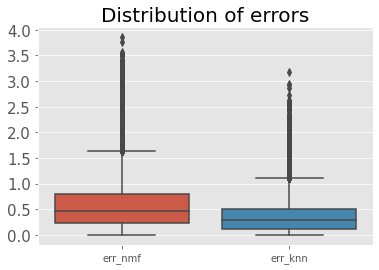

In [17]:
sns.boxplot(data=df_merged[['err_nmf', 'err_knn']])
plt.yticks(fontsize=15)
plt.title('Distribution of errors', fontsize=20);

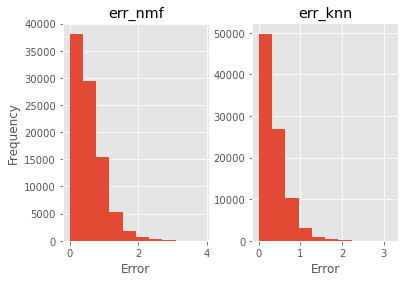

In [18]:
fig, ax = plt.subplots(1,2)
df_merged[['err_nmf']].hist(ax=ax[0])
ax[0].set_xlabel('Error')
ax[0].set_ylabel('Frequency')
df_merged[['err_knn']].hist(ax=ax[1])
ax[1].set_xlabel('Error');

In [19]:
df_merged[['err_nmf', 'err_knn']].describe()

# Numbers supporting the boxplots and histograms above
# Mean error of knn is smaller than mean error of NMF

,err_nmf,err_knn
count,91567.000000,91567.000000
mean,0.563246,0.354474
std,0.449209,0.314634
min,0.000000,0.000000
25%,0.227063,0.115567
50%,0.471816,0.285230
75%,0.790286,0.511404
max,3.853524,3.186729


In [20]:
# Shows errors for both models when error of knn is at least 2.5

df_merged[['err_nmf', 'err_knn']][df_merged.err_knn >= 2.5].sort_values(by='err_knn')

,err_nmf,err_knn
10048,2.767755,2.515272
30498,2.850985,2.525304
1424,2.897058,2.527739
26582,2.894924,2.530965
7800,3.393426,2.535374
57635,3.381867,2.570374
19688,2.753885,2.573634
57423,3.494242,2.579368
9819,3.360880,2.587356
51286,3.112910,2.621461


In [21]:
df_merged[['err_nmf', 'err_knn', 'Iu', 'Ui']][df_merged.err_knn >= 2.5].sort_values(by='err_knn')

,err_nmf,err_knn,Iu,Ui
10048,2.767755,2.515272,59,214
30498,2.850985,2.525304,75,179
1424,2.897058,2.527739,59,150
26582,2.894924,2.530965,60,98
7800,3.393426,2.535374,27,38
57635,3.381867,2.570374,97,18
19688,2.753885,2.573634,26,159
57423,3.494242,2.579368,24,39
9819,3.360880,2.587356,36,35
51286,3.112910,2.621461,50,63


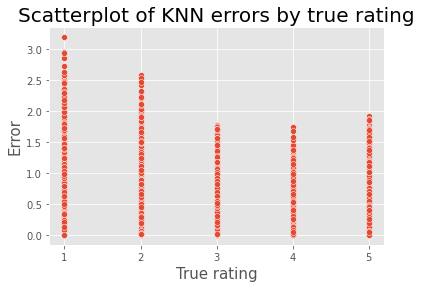

In [22]:
sns.scatterplot(data=df_merged, x = 'rui', y = 'err_knn')
plt.xticks(ticks=[1,2,3,4,5],labels=[1,2,3,4,5])
plt.xlabel("True rating", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
plt.title("Scatterplot of KNN errors by true rating", fontsize=20);

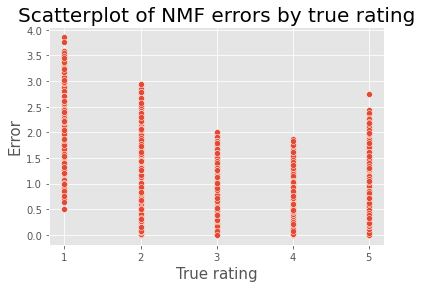

In [23]:
sns.scatterplot(data=df_merged, x = 'rui', y = 'err_nmf')
plt.xticks(ticks=[1,2,3,4,5],labels=[1,2,3,4,5])
plt.xlabel("True rating", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
plt.title("Scatterplot of NMF errors by true rating", fontsize=20);

In [24]:
df_merged[df_merged.Iu <5].err_knn.mean(), df_merged[df_merged.Iu <5].err_nmf.mean()

(0.2673762773049551, 0.5561647424399566)

In [25]:
df_merged[df_merged.Iu >40].err_knn.mean(), df_merged[df_merged.Iu >40].err_nmf.mean()

(0.32454422988621273, 0.5760252949984784)

In [26]:
Iu_df = df_merged[['Iu', 'err_nmf', 'err_knn']].groupby(['Iu']).mean()

In [32]:
Iu_df.head(2)

,err_nmf,err_knn
Iu,,
2,0.560294,0.209654
3,0.547344,0.255576


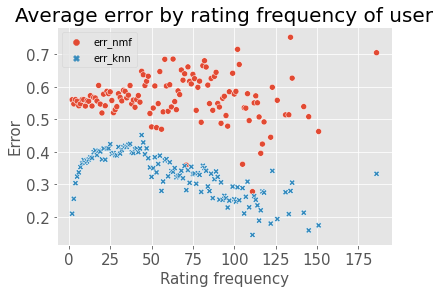

In [41]:
sns.scatterplot(data=Iu_df[['err_nmf', 'err_knn']])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Rating frequency", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
plt.title("Average error by rating frequency of user", fontsize=20);

In [29]:
Ui_df = df_merged[['Ui', 'err_nmf', 'err_knn']].groupby(['Ui']).mean()

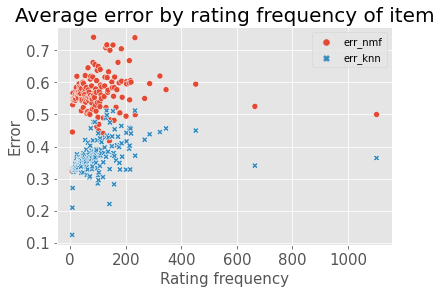

In [42]:
sns.scatterplot(data=Ui_df[['err_nmf', 'err_knn']])
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Rating frequency", fontsize = 15)
plt.ylabel("Error", fontsize = 15)
plt.title("Average error by rating frequency of item", fontsize=20);